# Introduction


Sumo is a sport held in high regard in Japan. It is the national sport and is rooted in tradition. Honor is expected of all the rikishi (wrestlers) and the Japan Sumo Association sees to it that the rikishi follow a certain code of conduct. When rikishi are found at odds with what is expected of them, discipline can be taken by the JSA up to expulsion from Sumo completely. Rikishi are given a salary based on their rank. Salary aside, rank is directly connected to notoriety. The Rikishi move up and down in rank depending on performance in the Basho, or tournaments, held every other month. A tournament consists of 15 days, where each rikishi has one match a day. In general, rikishi strive for at least a 8-7 record for each basho, known as a kachi-koshi, or "more wins than losses" record. A kachi-koshi ensures that at the very least the rikishi will keep their rank (and thus salary). On the other hand, a make-koshi or losing record can mean that the rank of the rikishi will be dropped (again, thus salary and notoriety).
        
Match-fixing accusations have been bandied about concerning Sumo matches for decades at this point. In 2011, an investigation into match fixing lead to the expulsion of 23 rikishi. Other alledged match-fixing happened in the eighties and nineties, though there were never any official investigations into match fixing or any disciplinary actions taken by the JSA (possibly due to involvement). As a side note, it is also alledged that the Yakuza, or Japanese mafia, were involved in the match-fixing as well, as they made money off the gambling rings they established.
    
In this project I will take a look at the results of all sumo matches over the last 36 or so years of the top two divisions to investigate suspicious wins. First I will verify that there is indeed an anomally that deserves to be investigated. From there, I will gather the names of the rikishi that seem to have been match fixing. To do this I will specifically be checking the rikishi's involvement in 7-7 matches, ie a match where either rikishi has a 7-7 record going into the last day (day 15) of the tournament. As described before, these are the most important matches possible for the rikishi that has the 7-7 as they determine if a rikishi falls in rank or goes up in rank. It is thus more likely for these matches to have been fixed than any other specific matches. Since when a match is fixed the loser is participating in match fixing as well, I will build up a count of how many matches where one of the rikishi (whether or not it is them) had a 7-7 record for each rikishi. From there I will do analysis on the results.

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
import csv
import matplotlib.pyplot as plt
import collections

plt.style.use("seaborn-darkgrid")

# Data Cleaning
<body>
        <span style='margin-left:36px'>The Data was obtained from data.world uploaded by a user by the name of MIKHAIL ZHILKIN. He scraped the data from the website sumodb.sumogames.de which is one of the most comprehensive databases on sumo information on the internet. Various sources are used as reference (nowadays often video) and the older results are pulled from old sumo magazines or old newspapers. Results are entered by a dedicated few individuals, and verified by many different users. Mistakes are possible but since the website has been up since around 2007, it is unlikely that any results are incorrect. The data was checked for zeros and NaNs earlier and it was found to be clean of these (in the spaces that 0s wouldnt apply). The data was found however, to have scraped every entry twice. The resulting .csv files are then twice as long as they need to be. Every other row will be dropped to shorten the runtime of the code.</span><br>
</body>

In [3]:
#all files have the same information, thus we will import one as a pandas dataframe
#and then concatenate the rest of the data from the other years using a loop 
matches = pd.read_csv("cervus-sumo-results/data/1983.csv")
for a in range(1984,2020):
    matches = pd.concat((matches,pd.read_csv("cervus-sumo-results/data/"+str(a)+".csv")))


<body>
        <span style='margin-left:36px'>About the dataframe and the information it holds. We have "basho" which is the date of the matches, "day" which is the day of the tournament on which the match was held, "rikishi1_id" which contains a unique identifying number to each of the rikishi since it is possible that they hold the same Shikona, or ring name. Next we have "rikishi1_rank" which contains the rank of rikishi1 at that time. it is in the form of a few letters and numbers and then another letter. This is the form of, for example "Y1e" which would be Yokozuna (highest rank), 1st position in the rank, east (ranks are separated into east and west, east being higher than west). "rikishi_shikona" is the ring name of the rikishi. rikishi1_result is the score of rikishi1 after that days match. so 0-1 indicates a loss on day 1. The numbers after indicate the final result of the tournament (7-8) being a 7 wins and 8 losses run on the tournament as a whole. rikishi1_win tells whether they lost or won the match, with the opposite value of the boolean on rikishi2_win. The last unique column is "kimarite" or winning technique. This indicates how the match was won ie "yorikiri" otherwise known as a frontal forceout.</span><br>
</body>

In [4]:
#dropping every other row
print("Old length of dataframe: " + str(len(matches)))
matches = matches.iloc[::2,:]
print("New length of dataframe: " + str(len(matches)))

Old length of dataframe: 214788
New length of dataframe: 107394


In [5]:
#make the date (year and month) the index
matches["basho"] = matches["basho"].astype(str)
#make the indices of the dataframe a month and year
matches.index = pd.to_datetime(matches["basho"],format="%Y.%m")


<body>
        <span style='margin-left:36px'>The columns "rikishi1_result" and "rikishi2_result" contain a string of numbers. They are in the form "X-Y (x-y)" where X is the total wins of the rikishi after that match, and Y is the total losses after that match. The lowercase x-y is the wins and losses total at the end of the tournament. The information is redundant at least 15x over but we might use it to study earlier matches based on the total standings of the tournament so keeping it on each row will make that easier. Using a regular expression I'll split the columns into 4 different values for each rikishi, each an int. "rikishi1_totalwins", "rikishi1_wins","rikishi1_totallosses", and "rikishi1_losses". The same thing will be done for rikishi2. The exception to this rule will be on day 15 of the each basho, but for our purposes we don't need to worry about the format of the new columns on day 15.</span><br>
</body>

In [6]:
regular = re.compile(r"^(\d\d?)-(\d\d?) \((\d\d?)-\d?-?(\d\d?)\)")
#with this regular expression i can use the same one for every entry
#this regular expression breaks on day 15, but doesn't raise any errors, as well as we don't need to
#look at those columns on day 15 as all the data we need is in the row on day 14
#the only data we'll need to get from day 15 eventually is who their opponent was
results1 = matches["rikishi1_result"].tolist()
results2 = matches["rikishi2_result"].tolist()
total1, total2, win1, win2, losstotal1, losstotal2, loss1, loss2 = [],[],[],[],[],[],[],[]
for a in range(len(results1)):
    total1.append(regular.sub(r"\3",results1[a]))
    total2.append(regular.sub(r"\3",results2[a]))
    win1.append(regular.sub(r"\1",results1[a]))
    win2.append(regular.sub(r"\1",results2[a]))
    loss1.append(regular.sub(r"\2",results1[a]))
    loss2.append(regular.sub(r"\2",results2[a]))
    losstotal1.append(regular.sub(r"\4",results1[a]))
    losstotal2.append(regular.sub(r"\4",results2[a]))
matches["rikishi1_totalwins"] = total1
matches["rikishi1_totallosses"] = losstotal1
matches["rikishi1_wins"] = win1
matches["rikishi1_losses"] = loss1
matches["rikishi2_totalwins"] = total2
matches["rikishi2_totallosses"] = losstotal2
matches["rikishi2_wins"] = win2
matches["rikishi2_losses"] = loss2

# Feature Engineering

I will now be extracting certain data from the dataframe I have. First I will create a dictionary that contains the unique ID of each rikishi mached to their shikona (ring name). From there I will start extracting the information about the 7-7 matches. I will look on day 14 of each basho for any rikishi that finished that day with a 7-7 record and record his ID and the ID of his opponent for day 15 and wether or not that match resulted in a win for the rikishi with the 7-7 record. First though, I will make a dictionary of all of the rikishi ID's matched to the shikona, or ring name of the rikishi. This way I can make graphs later on that are labeled by the rikishi's name instead of ID.

In [7]:
rikishinames ={}
#update the dictionary with both sides of the list just in case there is a
#rikishi that happens to only ever show up on one side of the dataset
for a in range(len(matches)):
    rikishinames[matches.iloc[a]["rikishi2_id"]]=matches.iloc[a]["rikishi2_shikona"]
    rikishinames[matches.iloc[a]["rikishi1_id"]]=matches.iloc[a]["rikishi1_shikona"]

<body>
        <span style='margin-left:36px'>The following code will go through the dataframe and check every match of the 14th day to see if there are any rikishi that have a 7-7 record going into day 15. From there if there is a rikishi with a 7-7 record, we record whether he won his match by checking his tournament record to see if its 8 wins. If he won the match, we add his ID and the ID of the rikishi he faced to a two separate lists. Like this we can count the involvement in 7-7 matches rather than just count the matches that a rikishi won while 7-7. This means that losing to a rikishi that is 7-7 will count for the same as if the rikishi had been 7-7 and won. On the other hand, if we check and see that the rikishi only had 7 wins at the end of the tournament, that means he lost his 7-7 match and thus we add his ID and the ID of the rikishi to whom he lost to two separate lists. Ideally we would see that there are roughly similar amounts of matches that result in the 7-7 rikishi winning and losing, if not skewed slightly to the side of the 7-7. Favoring the 7-7 rikishi slightly would make sense since they have extra motivation to win the match and if the other rikishi is not 7-7 then they already have a winning or losing record, and thus can afford a loss or don't care as much about the win since they have a make-koshi already.</span><br>
</body>

In [8]:
#i'll loop through the whole dataframe, but we'll do it more effectively by only checking the 14th day matches of each basho
bashos = matches.index.unique()
frame = []
for i in bashos:
    #each list will be reset for each basho
    #list of IDs of rikishi who lost to a 7-7 rikishi on the last day
    win77losers =[] 
    #list of IDs of rikishi who had a 7-7 record then won the last match
    win77winners = [] 
    #list of IDs of rikishi who had a 7-7 record then lost the last match
    loss77losers = [] 
    #list of IDs of rikishi who beat a rikishi that was 7-7
    loss77winners = [] 
    #total number of 7-7 matches for each basho
    match77 = 0 
    #number of 7-7 matches that resulted in a win for the 7-7 rikihsi
    match77win =0
    #number of 7-7 matches that resulted in a loss for the 7-7 rikishi
    match77loss = 0 
    #partial dataframes that contain only day 14 and 15 of the current basho
    current = matches[matches.index==i]
    current = current[current['day']==14]
    opponent_check = matches[matches.index==i]
    opponent_check = opponent_check[opponent_check['day'] == 15]
    for index,x in current.iterrows():
        #check the rikishi1_wins and rikishi2_wins columns of every row to search for 7-7 rikishi
        if (x['rikishi1_wins'] == '7') & (x['rikishi1_losses'] == '7'):
            #add the match to the total 7-7 matches
            match77 += 1 
            #check wether the rikishi then won or lost
            #then record the IDs of that rikishi and his opponent
            if x['rikishi1_totalwins'] == '8':
                #increase the win counter
                match77win+=1
                for index2,y in opponent_check.iterrows():
                    #find the ID of the opponent then add it to the opposite list
                    if y['rikishi1_id'] == x['rikishi1_id']:
                        win77losers.append(y['rikishi2_id'])
                    elif y['rikishi2_id'] == x['rikishi1_id']:
                        win77losers.append(y['rikishi1_id'])
                #add the rikishi's ID to the list
                win77winners.append(x.rikishi1_id)
            if x['rikishi1_totalwins'] == '7':
                #increase the loss counter
                match77loss+=1
                for index2,y in opponent_check.iterrows():
                    #find the ID of the opponent then add it to the opposite list
                    if y['rikishi1_id'] == x['rikishi1_id']:
                        loss77winners.append(y['rikishi2_id'])
                    elif y['rikishi2_id'] == x['rikishi1_id']:
                        loss77winners.append(y['rikishi1_id'])
                #add the rikishi's ID to the list
                loss77losers.append(x.rikishi1_id)
        #this code is the same as the first block, but checks the other column of rikishi
        if (x['rikishi2_wins'] == '7') & (x['rikishi2_losses'] == '7'):
            match77 += 1 
            if x['rikishi2_totalwins'] == '8':
                match77win+=1
                for index2,y in opponent_check.iterrows():
                    if y['rikishi1_id'] == x['rikishi2_id']:
                        win77losers.append(y['rikishi2_id'])
                    elif y['rikishi2_id'] == x['rikishi2_id']:
                        win77losers.append(y['rikishi1_id'])
                win77winners.append(x.rikishi2_id)
            if x['rikishi2_totalwins'] == '7':    
                match77loss+=1
                for index2,y in opponent_check.iterrows():
                    if y['rikishi1_id'] == x['rikishi2_id']:
                        loss77winners.append(y['rikishi2_id'])
                    elif y['rikishi2_id'] == x['rikishi2_id']:
                        loss77winners.append(y['rikishi1_id'])
                loss77losers.append(x.rikishi2_id)
    frame.append(tuple((i, match77, match77win, match77loss, win77winners, win77losers, loss77winners, loss77losers)))

I now have a relatively well formatted list of all the 7-7 matches in each basho. Each element of frame contains a tuple of the date of the basho, how many 7-7 matches there were, how many of those matches resulted in the 7-7 rikishi winning, how many of those matches resulted in the 7-7 rikishi losing, then we have 4 lists as the lasts elements in the tuple. The first two lists are the id's of the rikishi that won, and the rikishi that lost. Thus if there was a 7-7 match where the 7-7 rikishi won, his name will be the first element in the list, then the id of the loser will be the first element in the other list.
    
From here I will now examine the win-rate of all the 7-7 matches. As mentioned earlier, the winrate should average around .55-.6 since the rikishi will be more motivated to win the match than the other. There are about 236 points in the graph spanning from 1983 to 2019 so we will take a rolling average of the data so as to smooth out the graph and get a better representation of a general trend of 7-7 match win-rates

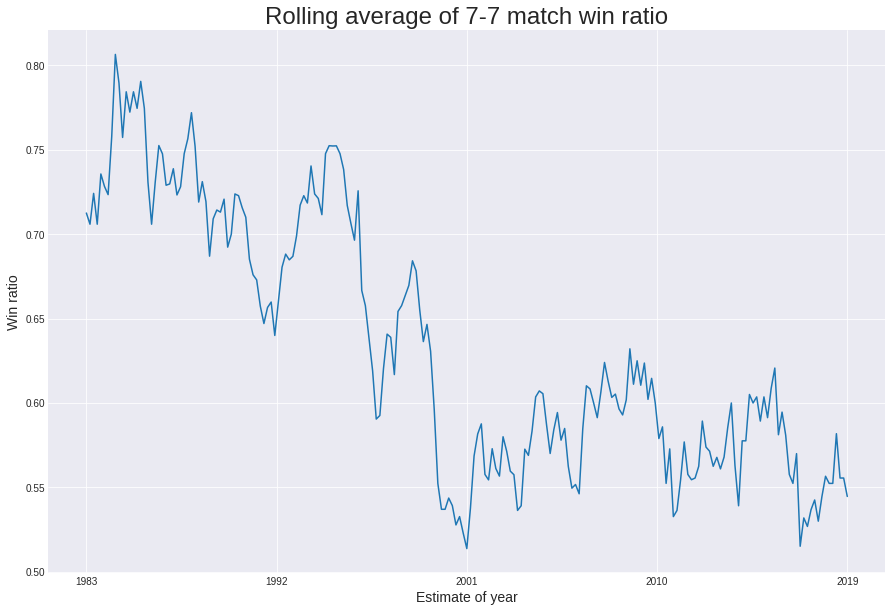

In [9]:
#I do a rolling average of 10 entries at a time (this translates to roughly a year and a bit of data)
y = [a for a in range(211)]
total= [x[1] for x in frame]
wins = [x[2] for x in frame]
#to do the rolling average, we convolve the total and wins lists with a 10 length array with values all 1/10
rollave = np.convolve(total, np.ones((10,))/10, mode='valid')
rollave1 = np.convolve(wins, np.ones((10,))/10, mode='valid')
plt.figure(figsize=(15,10))
plt.plot(y,rollave1/rollave,label='7-7 win-ratio')
plt.title("Rolling average of 7-7 match win ratio",fontsize = 24)
plt.ylabel("Win ratio",fontsize = 14)
plt.xlabel("Estimate of year",fontsize = 14)
plt.xticks([0,52.5,105,157.5,210],['1983','1992','2001','2010','2019'])
plt.savefig("7-7match_win_ratio.pdf")
plt.show()

There is clearly something suspicious going on here. The win ratio of 7-7 matches got as high as .8+ in the eighties and nineties. Even when averaged over about a year an a half, it was that high. This is a clear indicator of foul play during those times. It isn't surprising that the win rate never drops below .5 on average though. One should expect that a rikishi would gain motivation to win their match legitimately as well if their rank was on the line. Thus as we can see around 2001-2019 it stabilizes around .55 to .6. Another thing to point out though is the match fixing that we might be seeing around 2010. As mentioned before, there were 23 rikishi that were expelled from sumo due to match fixing. If that happened in 2011 then we can see that before that point there was a higher win rate than normal and after they were caught there appears to be a spike down (it might not match exactly on the graph as it is a rolling average, but we still can see general trends).

The dip around the year 2000 is when the media started covering the accusations of match fixing in sumo and a few whistle blowers came out against it. Despite this, official investigations were never made into this subject.

# Data Visualization

<body>
        <span style='margin-left:36px'>To visualize the data further, we will begin connecting the data to the rikishi. We will start by creating a bar graph of the IDs that appear most in each of the winning and losing 7-7 matches. After this we will examine the ratio of these to find initial suspicious rikishi. We only care for now about the data from the 80s and 90s so I will only go through 1999 in the list that I made.</span><br>
</body>

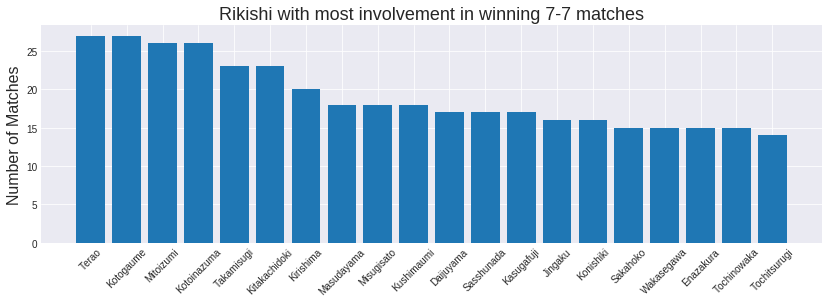

In [9]:
#entry 96 goes up to the first basho in 1999 I'll use that
ids = collections.Counter()
for basho in frame[:96]:
    for x in basho[4]:
        ids[x]+=1
    for x in basho[5]:
        ids[x]+=1
plt.figure(figsize=(14,4))
plt.bar([rikishinames[x] for x,y in ids.most_common()[:20]],[y for x,y in ids.most_common()[:20]])
plt.xticks(rotation=45)
plt.title("Rikishi with most involvement in winning 7-7 matches", fontsize=18)
plt.ylabel("Number of Matches",fontsize=16)
plt.show()

<body>
        <span style='margin-left:36px'>Involvement alone in many 7-7 matches where the 7-7 rikishi won is not damning evidence in and of itself though. But, it is very suspicious. I'll look at a ratio of involvement in 7-7 matches where the 7-7 rikishi won to the 7-7 matches where the 7-7 rikishi lost. For this I will use the other lists that I made in 'frame' and count up the involvement there too.</span><br>
</body>

In [10]:
losing = collections.Counter()
for basho in frame[:96]:
    for x in basho[6]:
        losing[x]+=1
    for x in basho[7]:
        losing[x]+=1
#since we now have two counters we can make a list of the rikishi's involvement in the winning and losing 7-7 matches

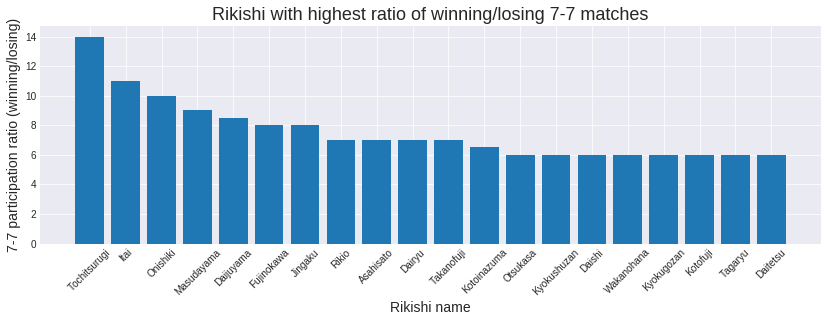

In [11]:
ratio,nolose= [],[]
for x in ids:
    if x in losing:
        if ids[x]+losing[x] >=5:
            ratio.append(tuple((x,ids[x],losing[x],ids[x]/losing[x])))
    else:
        nolose.append(tuple((x,ids[x])))
#having looked in the data where there were people that participated no losing 7-7 matches, there were only 3 that had
#5 or more participations in 7-7 matches where the 7-7 rikishi won
ratio = sorted(ratio, key=lambda tup: tup[3])
ratio.reverse()
ratid = [x[0] for x in ratio[:20]]
plt.figure(figsize=(14,4))
plt.bar([rikishinames[x]for x in ratid],[x[3] for x in ratio[:20]])
plt.xlabel("Rikishi name",fontsize=14)
plt.ylabel("7-7 participation ratio (winning/losing)",fontsize=14)
plt.title("Rikishi with highest ratio of winning/losing 7-7 matches",fontsize = 18)
plt.xticks(rotation=45)
plt.show()

Thus I have a list of rikishi that are likely to have been participating in match fixing. When the ratio is so high (I set the minimum number of participations in 7-7 matches {winning or losing} to be 5) we can assume that at the top certain percentage of rikishi here are at the very least more likely to have been participating in match fixing than their peers.
            
Just using a ratio is certainly not the best way to analyze this. Those with a lower amount of total matches (say 6) could have a higher ratio of win to loss participations than someone that has more matches (say 30) but still has a less likely outcome. ie having 5 win participations and 1 loss participation isn't as suspicious as having 25 win participations and 5 loss participations. The best way to analyze the amount of wins to losses then will be with a binomial distribution.The binomial distribution that I will use will have p=.58. This corresponds to a .58 win-rate for a rikishi with a 7-7 record on the last day. I get this from the rolling average graph above where the win-rate seemed to be around .58 when there was no obvious suspicious behavior in the graph. I will be taking the cdf distribution with the number of winning 7-7 match participations as a success and the total number of win/loss 7-7 matches as the number of 'trials'. I take 1 - (binomial cdf) to signify the odds that they have that many (or more) winning match participations relative to the losses.

In [12]:
from scipy.stats import binom
calc = binom.pmf(14,15,.58)
newlist = []
#we use the ratio list which contains only rikishi that have at least 5 matches or more
for x in ratio:
    #save the wins, losses, and the probability based on a binomial distribution with p=.58
    newlist.append(tuple((x[0],x[1],x[2],1-binom.cdf(x[1],x[1]+x[2],.58)))) 

<span style='margin-left:36px'>With this I now separate the rikishi into two groups: a group that is likely match fixing and a group that is less likely to be participating. I set the cutoff at 3%. With a list that is 136 rikishi long, given no match fixing one would suspect about 3-10 names to show up on this list.</span><br>

In [13]:
#make a list of the people likely to have been matchfixing and those who weren't as likely
cheaters, nonlikely = [],[]
for x in newlist:
    #I set the cutoff at 3 percent liklihood.
    if x[3] <=.03:
        cheaters.append(x)
print("Number of very likely cheaters: "+str(len(cheaters)))
for x in newlist:
    if x[3] >.03:
        nonlikely.append(x)
print("Number of not as likely: "+str(len(nonlikely)))

Number of very likely cheaters: 40
Number of not as likely: 96


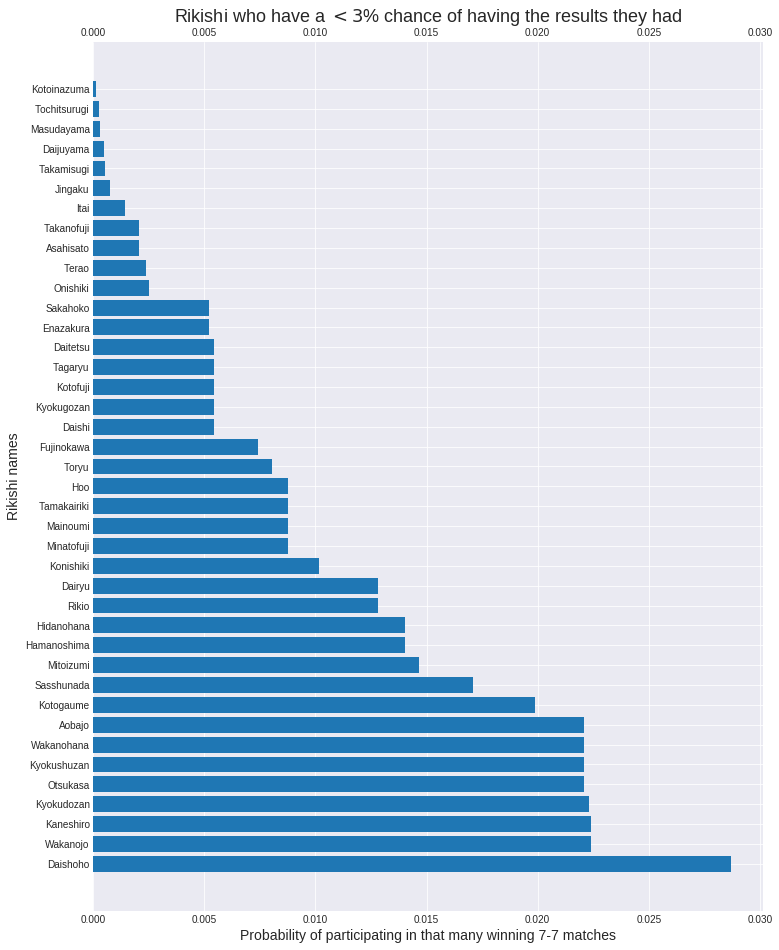

In [14]:
plt.figure(figsize=(12,16))
plt.tick_params(labeltop=True)
cheaters.sort(key=lambda elem: elem[3],reverse=True)
plt.barh([rikishinames[x[0]] for x in cheaters],[y[3] for y in cheaters])
plt.title("Rikishi who have a $<3$% chance of having the results they had", fontsize=18)
plt.xlabel("Probability of participating in that many winning 7-7 matches",fontsize=14)
plt.ylabel("Rikishi names",fontsize=14)
plt.show()

\begin{center}
\adjustimage{max size={0.9\linewidth}
{0.9\paperheight}}{sumotable.png}
\end{center}

# Conclusion
 
 <span style='margin-left:36px'>Match fixing was obviously rampant during the 80s and 90s. The list above is very generous in its reach. Multiple people came out during the time stating that at least 70% of matches were fixed. This means lowering the cutoff percentage (which I had set at 3%) will likely include many more people that were participating actively in match fixing. In my own opinion those listed above are almost 100% certain to have participated in match fixing, just based on suspicious matches. No official ruling can be made now since it was so long in the past and doesn't even matter anymore, but it is good to be able to look back and see who the honestly great rikishi were, and who probably cheated to get ahead (or help other rikishi maintain rank).</span><br>

In [15]:
print(cheaters)

[(45, 11, 3, 0.028693502589508424), (27, 9, 2, 0.02240181875876912), (4100, 9, 2, 0.02240181875876912), (1295, 14, 4, 0.022295114340775468), (63, 6, 1, 0.022079841675520018), (35, 6, 1, 0.022079841675520018), (3, 6, 1, 0.022079841675520018), (4102, 6, 1, 0.022079841675520018), (1292, 27, 10, 0.01985823105422102), (1333, 17, 5, 0.01707072164430945), (28, 26, 9, 0.014680938517870445), (25, 10, 2, 0.01404249392809298), (1380, 10, 2, 0.01404249392809298), (1289, 7, 1, 0.012806308171801617), (1297, 7, 1, 0.012806308171801617), (1287, 16, 4, 0.010170370115304306), (16, 11, 2, 0.008753321126138025), (42, 11, 2, 0.008753321126138025), (1309, 11, 2, 0.008753321126138025), (1378, 11, 2, 0.008753321126138025), (1369, 14, 3, 0.008049647460896758), (4137, 8, 1, 0.0074276587396449045), (62, 12, 2, 0.005429957548909625), (1305, 12, 2, 0.005429957548909625), (1303, 12, 2, 0.005429957548909625), (1352, 12, 2, 0.005429957548909625), (1361, 12, 2, 0.005429957548909625), (1315, 15, 3, 0.005200554084921038